In [4]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
import re  # regex
from PIL import Image, ImageDraw
import random
from scipy.stats import sem, ttest_ind, norm
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.cm as cm
import pickle

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection
from lib.analysis.correlation import FunctionalConnectivityMatrix

# 2-way ANOVA for medial and lateral PPR vs IPI
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm


In [5]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/"
ppr_coronal_df = data_dir + "export_summary_backup_coronal.csv"
ppr_sagittal_df = data_dir + "export_summary_backup_sagittal.csv"
data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR_single_pixel/"
ppr_single_px_df = data_dir + "export_summary_backup_single_px.csv"

camera_program = 4
um_per_px = 6.0 #um

# load the CSVs
ppr_coronal_df = pd.read_csv(ppr_coronal_df)
ppr_sagittal_df = pd.read_csv(ppr_sagittal_df)
ppr_single_px_df = pd.read_csv(ppr_single_px_df)

# add column for Coronal/Sagittal
ppr_coronal_df['Section'] = 'Coronal'
ppr_sagittal_df['Section'] = 'Sagittal'

# merge ppr_coronal_df and ppr_sagittal_df into barrel_ppr_df
ppr_barrel_df =  ppr_coronal_df.append(ppr_sagittal_df)

# combine the dataframes or use single px only
ppr_df = ppr_single_px_df #ppr_coronal_df.append(ppr_sagittal_df)

output_fig_dir = 'P:/John/crossing-paper/input/'
ppr_barrel_df

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,trace_non_polyfit,amp_array,Medial/Lateral,Section,Rostral/Caudal
0,1,0.479013,120.492,18.61820,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
1,2,0.330619,120.585,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN
2,1,0.176925,182.307,3.53397,51.660221,53.138122,1_rois pulse2,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
3,2,0.078507,182.489,7.29899,44.112853,28.366771,1_rois pulse2,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN
4,1,0.590332,120.014,12.29530,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,2,5.388340,142.602,5.38834,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,25,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral
1214,1,5.504880,143.043,5.50488,58.472131,43.518033,3_rois pulse1,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Home
1215,2,7.391860,141.078,7.39186,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral
1216,1,7.935810,185.029,7.93581,58.472131,43.518033,3_rois pulse2,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Home


In [6]:
# load PPR catalog
ppr_catalog = data_dir + "ppr_catalog_backup-both.csv"
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and is_single_pulse_control columns
#ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'is_single_pulse_control']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}/{d}/20{y}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)
ppr_catalog_df


,zda_file,pulse1_start,pulse1_width,pulse2_start,pulse2_width,baseline_start,baseline_width,IPI,is_single_pulse_control,done,Coronal/Sagittal,zda_id,Slice,Location,Recording,Date
0,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01,1,3,1,1/2/2025
1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,NaN,NaN,236,100,60,1,1.0,Coronal,01_03_02,1,3,2,1/2/2025
2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,NaN,NaN,276,100,40,1,1.0,Coronal,01_03_03,1,3,3,1/2/2025
3,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,356.0,70.0,276,180,40,0,1.0,Coronal,01_03_04,1,3,4,1/2/2025
4,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,336,20,356.0,70.0,336,120,10,0,1.0,Coronal,01_03_05,1,3,5,1/2/2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,116,70,NaN,NaN,116,100,120,1,NaN,Sagittal,03_02_22,3,2,22,4/16/2025
670,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,176,70,356.0,70.0,176,280,90,0,NaN,Sagittal,03_02_23,3,2,23,4/16/2025
671,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,176,70,NaN,NaN,176,100,90,1,NaN,Sagittal,03_02_24,3,2,24,4/16/2025
672,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,NaN,NaN,276,100,40,1,NaN,Sagittal,03_02_25,3,2,25,4/16/2025


In [7]:
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

# merge the two dataframes, using date, slice, location, and recording as keys
ppr_df = ppr_df.merge(ppr_catalog_df, on=['Date', 'Slice', 'Location', 'Recording'])

# drop the zda_file column
ppr_df.drop('zda_file', axis=1, inplace=True)

ppr_df

,ROI_File,ROI_Set,Date,Slice,Location,Recording,trace,pulse1_start,pulse1_width,pulse2_start,pulse2_width,baseline_start,baseline_width,IPI,is_single_pulse_control,done,Coronal/Sagittal,zda_id
0,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,01_rois_output__rand_0,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01
1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,01_rois_output__rand_1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01
2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,01_rois_output__rand_0,1/2/2025,1,3,2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,NaN,NaN,236,100,60,1,1.0,Coronal,01_03_02
3,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,01_rois_output__rand_1,1/2/2025,1,3,2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,NaN,NaN,236,100,60,1,1.0,Coronal,01_03_02
4,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,01_rois_output__rand_0,1/2/2025,1,3,3,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,NaN,NaN,276,100,40,1,1.0,Coronal,01_03_03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,04_rois_output__rand_1,4/9/2025,4,2,25,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,216,70,356.0,70.0,216,240,70,0,NaN,Sagittal,04_02_25
1530,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,04_rois_output__rand_2,4/9/2025,4,2,25,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,216,70,356.0,70.0,216,240,70,0,NaN,Sagittal,04_02_25
1531,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,04_rois_output__rand_0,4/9/2025,4,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,216,70,NaN,NaN,216,100,70,1,NaN,Sagittal,04_02_26
1532,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,04_rois_output__rand_1,4/9/2025,4,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,216,70,NaN,NaN,216,100,70,1,NaN,Sagittal,04_02_26


In [8]:
# now use the StaticFC class to calculate the functional connectivity matrix
# of the PPR data.
# Use the ppr_catalog_df to get the measure window(s) for each recording
# and pass that to the StaticFC class as the measure_window argument,
# per the StaticFC class docstring.
# The measure window is the time window in which to calculate the functional connectivity matrix.
# It is a tuple of the form (start_time, end_time) in ms.

# set matplotlib font to size 22
plt.rcParams.update({'font.size': 22})

missing_files = []
max_lag = 15
lags = [l for l in range(0, max_lag)]
total_rdm_distances = [[] for _ in lags]
corr_matrices = {}
corr_matrices_by_slice = {}
trace_sets_dict = {}
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]
        for loc in slic_df['Location'].unique():
            loc_df = slic_df[slic_df['Location'] == loc]
            slic_loc_id = f"{slic}_{loc}"
            
            n_ipis = len(loc_df['IPI'].unique())
            
            fig, ax = plt.subplots(n_ipis * 2, 3, figsize=(30, 10 * n_ipis * 2))
            i_ipi = -1
            for ipi in loc_df['IPI'].unique():
                ipi_df = loc_df[loc_df['IPI'] == ipi]
                i_ipi += 1
                
                for control_or_ppr_type in ipi_df['is_single_pulse_control'].unique():
                    control_df = ipi_df[ipi_df['is_single_pulse_control'] == control_or_ppr_type]
                    i_plot = i_ipi * 2 + control_or_ppr_type
                    trace_dict = {}
                    # get the measure windows for this recording
                    measure_windows = ppr_catalog_df[(ppr_catalog_df['Slice'] == slic) & 
                                                    (ppr_catalog_df['Location'] == loc) & 
                                                    (ppr_catalog_df['Date'] == date) & 
                                                    (ppr_catalog_df['IPI'] == ipi) &
                                                    (ppr_catalog_df['is_single_pulse_control'] 
                                == control_or_ppr_type)][['pulse1_start', 
                                                            'pulse1_width', 
                                                            'pulse2_start', 
                                                            'pulse2_width']].values
                    pulse1_start = int(measure_windows[0][0])
                    pulse1_width = int(measure_windows[0][1])
                    pulse2_start = measure_windows[0][2]
                    pulse2_width = measure_windows[0][3]

                    m_windows = []
                    measure_window1 = (pulse1_start, pulse1_start + pulse1_width)
                    # if pulse2_start is nan, don't use the second measure window
                    if not np.isnan(pulse2_start):
                        measure_window2 = (int(pulse2_start), 
                                           int(pulse2_start) + int(pulse2_width))
                        m_windows.append(measure_window1)
                        m_windows.append(measure_window2)
                    else:
                        m_windows.append(measure_window1)

                    # grab the trace files from the ppr_df for this recording
                    # there should be at least 2 trace files, one for each ROI
                    trace_files = control_df['trace'].values
                    if len(trace_files) < 2:
                        print("Not enough traces for this recording")
                        continue
                    
                    # we can tell which barrel it is by the trace filename last digit before .dat 
                    for trace_file in trace_files:
                        if '_rand_' not in trace_file:
                            continue
                        i_barrel = int(trace_file.split('_rand_')[1][0])
                        
                        try:
                            traces = read_dat_trace_file(trace_file)
                        except FileNotFoundError:
                            missing_files.append(trace_file)
                            continue
                        if i_barrel not in trace_dict:
                            trace_dict[i_barrel] = []
                        # traces is a pandas dataframe, with columns ['Pt', 'ROI1', 'ROI2', ...]
                        # where each ROI is a time series for a pixel.
                        # convert this to a List of time series (e.g., pixels) from the first set.
                        trace_dict[i_barrel] += ([traces[r] 
                                                for r in traces.columns if r != 'Pt'])

                    # store the trace_dict in the trace_sets_dict
                    if date not in trace_sets_dict:
                        trace_sets_dict[date] = {}
                    if slic_loc_id not in trace_sets_dict[date]:
                        trace_sets_dict[date][slic_loc_id] = {}
                    if ipi not in trace_sets_dict[date][slic_loc_id]:
                        trace_sets_dict[date][slic_loc_id][ipi] = {}
                    if control_or_ppr_type not in trace_sets_dict[date][slic_loc_id][ipi]:
                        trace_sets_dict[date][slic_loc_id][ipi][control_or_ppr_type] = {}
                    trace_sets_dict[date][slic_loc_id][ipi][control_or_ppr_type] = trace_dict

                    barrels = list(trace_dict.keys())
                    i = 0
                    j = 1
                    if i not in barrels or j not in barrels:
                        continue
                    #for i in range(len(barrels)):
                        #for j in range(i+1, len(barrels)):
                    fc = FunctionalConnectivityMatrix(measure_windows=m_windows)
                    print("Date:", date, "Slice:", slic, "Location:", loc, "IPI:", ipi,
                            "Control or PPR type:", control_or_ppr_type)
                    print("Barrels ", barrels[i], #"set:", trace_dict[barrels[i]],
                        'len:', len(trace_dict[barrels[i]]))
                    print("Barrels ", barrels[j], #"set:", trace_dict[barrels[j]],
                        'len:', len(trace_dict[barrels[j]]))
                    print("Trace files: ", trace_files)

                    for lag in lags:
                        print("\tLag: ", lag)
                        static_matrix = fc.compute_correlation(trace_dict[barrels[i]][:100],
                                                        trace_dict[barrels[j]][:100],
                                                        method='pearson',
                                                        lag=lag,)

                        # store correlation matrix in the corr_matrices dict
                        if date not in corr_matrices_by_slice:
                            corr_matrices_by_slice[date] = {}
                        if slic_loc_id not in corr_matrices_by_slice[date]:
                            corr_matrices_by_slice[date][slic_loc_id] = {}
                        if ipi not in corr_matrices_by_slice[date][slic_loc_id]:
                            corr_matrices_by_slice[date][slic_loc_id][ipi] = {}
                        if control_or_ppr_type not in corr_matrices_by_slice[date][slic_loc_id][ipi]:
                            corr_matrices_by_slice[date][slic_loc_id][ipi][control_or_ppr_type] = {}
                        if lag not in corr_matrices_by_slice[date][slic_loc_id][ipi][control_or_ppr_type]:
                            corr_matrices_by_slice[date][slic_loc_id][ipi][control_or_ppr_type][lag] = []
                        corr_matrices_by_slice[date][slic_loc_id][ipi][control_or_ppr_type][lag].append(static_matrix)
                        
                        if ipi not in corr_matrices:
                            corr_matrices[ipi] = {}
                        if control_or_ppr_type not in corr_matrices[ipi]:
                            corr_matrices[ipi][control_or_ppr_type] = {}
                        if lag not in corr_matrices[ipi][control_or_ppr_type]:
                            corr_matrices[ipi][control_or_ppr_type][lag] = []
                        corr_matrices[ipi][control_or_ppr_type][lag].append(static_matrix)

                    # visualize the static matrix
                    # make 3 subplots
                    ax[i_plot][0].imshow(static_matrix, cmap='hot', interpolation='nearest',
                        vmin=0, vmax=1)

                    ax[i_plot][0].set_title(f"Static FC: {slic_loc_id} {ipi} {control_or_ppr_type} "
                                f"Barrels {barrels[i]} and {barrels[j]}")

                    
                    # in the other subplot, show histogram of strengths of the connections
                    ax[i_plot][1].hist(static_matrix[np.isfinite(static_matrix)].flatten(), bins=100, color='blue', alpha=0.5)
                    ax[i_plot][1].set_xlabel('Correlation')
                    
                                                
                    #plt.show()

                    # in the 3rd subplot, plot some example trace pairs (one from each barrel)
                    # and annotate with the correlation value
                    baseline = 0
                    for k in range(5):
                        
                        i_rand = random.randint(0, 99)
                        j_rand = random.randint(0, 99)
                        ax[i_plot][2].plot(trace_dict[barrels[i]][i_rand] + baseline, color='blue', alpha=0.5)
                        ax[i_plot][2].plot(trace_dict[barrels[j]][j_rand] + baseline, color='red', alpha=0.5)
                        
                        # annotate the plot with the correlation value near the baseline value
                        # get the correlation value from the static_matrix
                        # the correlation value is the value at (i_rand, j_rand) in the static_matrix
                        corr = static_matrix[i_rand, j_rand]
                        ax[i_plot][2].annotate(f"Corr: {corr:.2f}", 
                                    xy=(0, baseline), 
                                    xytext=(0, baseline + 0.5),
                                    arrowprops=dict(facecolor='black', shrink=0.05),
                                    fontsize=12)
                        baseline += max(trace_dict[barrels[i]][i_rand].max(), 
                                        trace_dict[barrels[j]][j_rand].max()) * 1.1

            # legend shows that blue is barrel i and red is barrel j
            # if i,j == 0 label home barrel, else label barrel neighbor
            ax[0][2].legend(["Home Barrel" if k_r == 0 else "Barrel Neighbor" 
                        for k_r in [i, j]], loc='upper right')

            if not (i in barrels and j in barrels):
                plt.close(fig)
                continue

            plt.savefig(f"{output_fig_dir}/{slic_loc_id}_"
                        f"static_fc_{barrels[i]}_{barrels[j]}-xcorr.png")   

            plt.tight_layout()
            #plt.show()
            plt.close(fig)

            # Now, for each pair of (ipi1, is_single_pulse_control1) and (ipi2, is_single_pulse_control2),
            # calculate the dissimiarity of the static FC matrices.
            # Store that value in a representational dissimilarity matrix (RDM).
            # The RDM is a square matrix of size n x n, where n is the number of pairs of (ipi, is_single_pulse_control).
            # The first n/2 values are the (ipi1, is_single_pulse_control1) values for which is_single_pulse_control == 0,
            # and the second n/2 values are the (ipi2, is_single_pulse_control2) values for which is_single_pulse_control == 1.
            
            ipi_list = list(corr_matrices.keys())
            rdm = np.zeros((len(ipi_list) * 2, len(ipi_list) * 2))
            # sort
            ipi_list.sort()
            for lag in lags:
                for i_ipi in range(len(ipi_list)):
                    ipi = ipi_list[i]
                    for control_or_ppr_type in corr_matrices[ipi].keys():
                        i_rdm = i_ipi + (len(ipi_list) * control_or_ppr_type)
                        fc1 = corr_matrices[ipi][control_or_ppr_type][lag][-1]

                        for j_ipi in range(i_ipi + 1, len(ipi_list)):
                            ipi2 = ipi_list[j_ipi]
                            for control_or_ppr_type2 in corr_matrices[ipi2].keys():
                                j_rdm = j_ipi + (len(ipi_list) * control_or_ppr_type2)
                                fc2 = corr_matrices[ipi2][control_or_ppr_type2][lag][-1]

                                # calculate the dissimilarity between the two matrices (sum of squared differences)
                                rdm[i_rdm][j_rdm] = np.sum((fc1 - fc2) ** 2)
                                rdm[j_rdm][i_rdm] = rdm[i_rdm][j_rdm]

                # show the RDM as a heatmap
                fig, ax = plt.subplots(figsize=(10, 10))
                plt.imshow(rdm, cmap='hot', interpolation='nearest') #, vmin=0, vmax=7000)
                plt.colorbar()
                plt.title(f"RDM: {date} {slic_loc_id} ")
                
                # label IPIs ticks where is_single_pulse_control == 0
                plt.xticks(np.arange(len(ipi_list)), 
                            [f"{ipi} ms" for ipi in ipi_list], rotation=45)
                plt.yticks(np.arange(len(ipi_list)),
                            [f"{ipi} ms" for ipi in ipi_list])
                plt.xlabel('Recording')
                plt.ylabel('Recording')
                plt.title(f"RDM: {date} {slic_loc_id} ")
                plt.tight_layout()
                date_formatted = date.replace('/', '-')
                plt.savefig(f"{output_fig_dir}/{date_formatted}_{slic_loc_id}_"
                            f"rdm-xcorr.png")
                #plt.show()
                plt.close(fig)

                total_rdm_distances[lag].append(np.sum(rdm))

# save total_rdm_distances and corr_matrices and corr_matrices_by_slice to a pickle file
with open(f"{output_fig_dir}/total_rdm_distances.pkl", 'wb') as f:
    pickle.dump(total_rdm_distances, f)
with open(f"{output_fig_dir}/corr_matrices.pkl", 'wb') as f:
    pickle.dump(corr_matrices, f)
with open(f"{output_fig_dir}/corr_matrices_by_slice.pkl", 'wb') as f:
    pickle.dump(corr_matrices_by_slice, f)
                        

print(len(missing_files), "missing files")
for missing_file in missing_files:
    print("\t", missing_file)

Date: 12/23/2024 Slice: 1 Location: 3 IPI: 130 Control or PPR type: 1
Barrels  0 len: 100
Barrels  1 len: 100
Trace files:  ['C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR_single_pixel/PPR_coronal_annotated\\12-23-24\\converted_zda/_01_03_01_trace_01_rois_output__rand_0.dat'
 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR_single_pixel/PPR_coronal_annotated\\12-23-24\\converted_zda/_01_03_01_trace_01_rois_output__rand_1.dat']
	Lag:  0
	Lag:  1
	Lag:  2
	Lag:  3
	Lag:  4
	Lag:  5
	Lag:  6
	Lag:  7
	Lag:  8
	Lag:  9
	Lag:  10
	Lag:  11
	Lag:  12
	Lag:  13
	Lag:  14
Date: 12/23/2024 Slice: 1 Location: 3 IPI: 130 Control or PPR type: 0
Barrels  0 len: 100
Barrels  1 len: 100
Trace files:  ['C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR_single_pixel/PPR_coronal_annotated\\12-23-24\\converted_zda/_01_03_02_trace_01_rois_output__rand_0.dat'
 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR_single_pixel/PPR_coronal_annotated\\12-23-24\\converted_zda/_01_03_02_trace_01_rois_output__rand_1.dat'

In [ ]:
# pull from pickle files
with open(f"{output_fig_dir}/total_rdm_distances.pkl", 'rb') as f:
    total_rdm_distances = pickle.load(f)
with open(f"{output_fig_dir}/corr_matrices.pkl", 'rb') as f:
    corr_matrices = pickle.load(f)
with open(f"{output_fig_dir}/corr_matrices_by_slice.pkl", 'rb') as f:
    corr_matrices_by_slice = pickle.load(f)

In [ ]:
# Control FCMs: use 2 barrels of same IPI and is_single_pulse_control,
# but different date, slice, and/or location.
# choose several examples and create the FCM and histogram for each.
# use the stored examples in trace_sets_dict to create the control examples.
control_rdm_distances = []
num_control_examples = 10
max_rows = 12
while num_control_examples > 0:
    # choose a random date, slice, and location from the trace_sets_dict
    date1 = random.choice(list(trace_sets_dict.keys()))
    slic_loc_id1 = random.choice(list(trace_sets_dict[date1].keys()))
    date2 = random.choice(list(trace_sets_dict.keys()))
    slic_loc_id2 = random.choice(list(trace_sets_dict[date2].keys()))

    # ensure they are not the same date, slice, and location
    while slic_loc_id1 == slic_loc_id2 and date1 == date2:
        date2 = random.choice(list(trace_sets_dict.keys()))
        slic_loc_id2 = random.choice(list(trace_sets_dict[date2].keys()))

    ipi_choices = list(trace_sets_dict[date1][slic_loc_id1].keys())
    ipi_choices = list(set(ipi_choices) & set(trace_sets_dict[date2][slic_loc_id2].keys()))
    if len(ipi_choices) == 0:
        print("No IPI choices for this date/slice/location pair")
        continue
    n_ipis = len(ipi_choices)
    fig, ax = plt.subplots(min(max_rows, n_ipis * 2), 3, figsize=(30, 10 * min(max_rows, n_ipis * 2)))
    i_ipi = -1
    control_corr_matrices = {}
    for ipi in ipi_choices:
        i_ipi += 1

        control_ppr_choices = list(trace_sets_dict[date1][slic_loc_id1][ipi].keys())
        control_ppr_choices = list(set(control_ppr_choices) &
            set(trace_sets_dict[date2][slic_loc_id2][ipi].keys()))

        for control_or_ppr_type in control_ppr_choices:

            i_plot = 2 * i_ipi + control_or_ppr_type
                

            try:
                barrels1 = trace_sets_dict[date1][slic_loc_id1][ipi][control_or_ppr_type]
                barrels2 = trace_sets_dict[date2][slic_loc_id2][ipi][control_or_ppr_type]
                traces1 = barrels1[0]
                traces2 = barrels2[1]
            except KeyError:
                print("one of the date/slice/locations does not have the IPI/control_or_ppr_type requested")
                continue
            

            # create the functional connectivity matrix
            fc = FunctionalConnectivityMatrix(measure_windows=m_windows)
            static_matrix = fc.compute_correlation(traces1, traces2,
                                        method='pearson',)

            # store correlation matrix in the corr_matrices dict
            if ipi not in control_corr_matrices:
                control_corr_matrices[ipi] = {}
            control_corr_matrices[ipi][control_or_ppr_type] = static_matrix

            print("Static matrix shape: ", static_matrix.shape)

            # visualize the static matrix
            # make 2 subplots
            
            if i_plot < max_rows:
                ax[i_plot][0].imshow(static_matrix, cmap='hot', interpolation='nearest',
                    vmin=0, vmax=1)

                ax[i_plot][1].set_title(f"Control FC: {date1} {slic_loc_id1} Home Barrel and "
                            f"{date2} {slic_loc_id2} Neighbor Barrel " + (f" for IPI {ipi} ms " if control_or_ppr_type == 0 else ""))

                
                # in the other subplot, show histogram of strengths of the connections
                ax[i_plot][1].hist(static_matrix.flatten(), bins=100, color='blue', alpha=0.5)
                ax[i_plot][1].set_xlabel('Correlation')
            
                # show random trace pairs (one from each barrel)
                baseline = 0
                for k in range(5):
                    i_rand = random.randint(0, len(traces1) - 1)
                    j_rand = random.randint(0, len(traces2) - 1)
                    ax[i_plot][2].plot(traces1[i_rand] + baseline, color='blue', alpha=0.5)
                    ax[i_plot][2].plot(traces2[j_rand] + baseline, color='red', alpha=0.5)
                    
                    # annotate the plot with the correlation value near the baseline value
                    # get the correlation value from the static_matrix
                    # the correlation value is the value at (i_rand, j_rand) in the static_matrix
                    corr = static_matrix[i_rand, j_rand]
                    ax[i_plot][2].annotate(f"Corr: {corr:.2f}", 
                                xy=(0, baseline), 
                                xytext=(0, baseline + 0.5),
                                arrowprops=dict(facecolor='black', shrink=0.05),
                                fontsize=12)
                    baseline += max(traces1[i_rand].max(), traces2[j_rand].max()) * 1.1
            
    if len(control_corr_matrices.keys()) == 0:
        print("No correlation matrices found")
        plt.close(fig)
        continue
    plt.savefig(f"{output_fig_dir}/{slic_loc_id}_"
                f"static_fc_control-xcorr.png")
    #plt.show()
    plt.close(fig)

    # compute RDM for the control examples
    # The RDM is a square matrix of size n x n, where n is the number of pairs of (ipi, is_single_pulse_control).
    # The first n/2 values are the (ipi1, is_single_pulse_control1) values for which is_single_pulse_control == 0,
    # and the second n/2 values are the (ipi2, is_single_pulse_control2) values for which is_single_pulse_control == 1.
    # The RDM is a square matrix of size n x n, where n is the number of pairs of (ipi, is_single_pulse_control).
    # The first n/2 values are the (ipi1, is_single_pulse_control1) values for which is_single_pulse_control == 0,
    # and the second n/2 values are the (ipi2, is_single_pulse_control2) values for which is_single_pulse_control == 1.
    ipi_list = list(control_corr_matrices.keys())
    ipi_list.sort()
    rdm = np.zeros((len(ipi_list) * 2, len(ipi_list) * 2))

    for i_ipi in range(len(ipi_list)):
        ipi = ipi_list[i_ipi]
        for control_or_ppr_type in control_corr_matrices[ipi].keys():
            i_rdm = i_ipi + (len(ipi_list) * control_or_ppr_type)
            fc1 = control_corr_matrices[ipi][control_or_ppr_type]

            for j_ipi in range(i_ipi + 1, len(ipi_list)):
                ipi2 = ipi_list[j_ipi]
                for control_or_ppr_type2 in control_corr_matrices[ipi2].keys():
                    j_rdm = j_ipi + (len(ipi_list) * control_or_ppr_type2)
                    fc2 = control_corr_matrices[ipi2][control_or_ppr_type2]

                    # calculate the dissimilarity between the two matrices (sum of squared differences)
                    rdm[i_rdm][j_rdm] = np.sum((fc1 - fc2) ** 2)
                    rdm[j_rdm][i_rdm] = rdm[i_rdm][j_rdm]
    # show the RDM as a heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(rdm, cmap='hot', interpolation='nearest') #, vmin=0, vmax=7000)
    plt.colorbar()
    plt.title(f"Control RDM: {date1} {slic_loc_id1} and {date2} {slic_loc_id2}")

    # label IPIs ticks where is_single_pulse_control == 0
    plt.xticks(np.arange(len(ipi_list)), 
                [f"{ipi} ms" for ipi in ipi_list], rotation=45)
    plt.yticks(np.arange(len(ipi_list)),
                [f"{ipi} ms" for ipi in ipi_list])
    plt.xlabel('Recording')
    plt.ylabel('Recording')
    plt.title(f"Control RDM: {date1} {slic_loc_id1} and {date2} {slic_loc_id2}")
    plt.tight_layout()
    plt.savefig(f"{output_fig_dir}/{date1}_{slic_loc_id1}_{date2}_{slic_loc_id2}_"
                f"rdm_control-xcorr.png")
    #plt.show()
    control_rdm_distances.append(np.sum(rdm))
    num_control_examples -= 1

t-statistic: -3.3982888468291583, p-value: 0.0036734059484250813
The two groups are significantly different


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_1636\438266485.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([0, 1], ['Data', 'Control'])


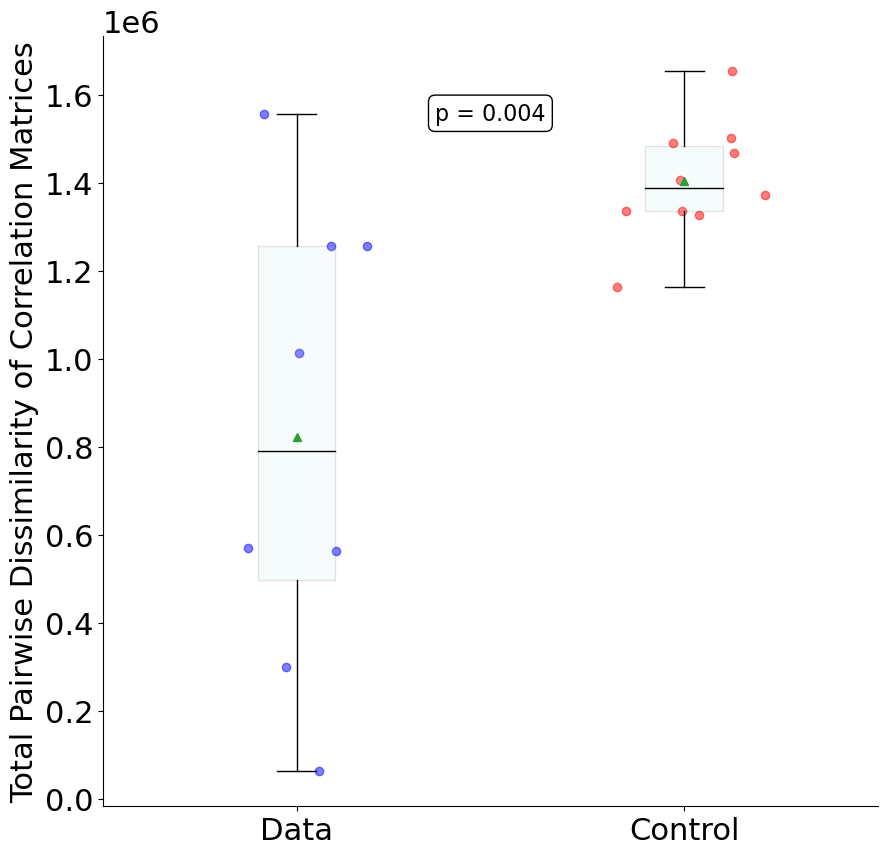

In [ ]:
# scatter plot of the total_rdm_distances and control_rdm_distances
fig, ax = plt.subplots(figsize=(10, 10))


# add box and whisker plot for each group
# make boxplot transparent
ax.boxplot([total_rdm_distances[0], control_rdm_distances], 
            positions=[0, 1], widths=0.2, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.1),
            showfliers=False,
            medianprops=dict(color='black'), showmeans=True)
            
x_jitter = np.random.normal(0, 0.1, len(total_rdm_distances[0]))
x_jitter2 = np.random.normal(0, 0.1, len(control_rdm_distances)) + 1
ax.scatter(x_jitter, total_rdm_distances[0], color='blue', alpha=0.5, label='Data')
ax.scatter(x_jitter2, control_rdm_distances, color='red', alpha=0.5, label='Control (scrambled)')

# use ttest_ind to compare the two groups
t_stat, p_val = ttest_ind(total_rdm_distances[0], control_rdm_distances)
print(f"t-statistic: {t_stat}, p-value: {p_val}")
if p_val < 0.05:
    print("The two groups are significantly different")
    # mark the p-value on the plot
    ax.annotate(f"p = {p_val:.3f}", xy=(0.5, 0.9), xycoords='axes fraction',
                fontsize=16, ha='center', va='center', color='black',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

ax.set_xlim(-0.5, 1.5)
ax.set_xticks([0, 1], ['Data', 'Control'])
ax.set_xticklabels(['Data', 'Control'])

# turn of spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Total Pairwise Dissimilarity of Correlation Matrices')
plt.savefig(f"{output_fig_dir}/total_rdm_distances_lag_0.png")
plt.show()
plt.close(fig)

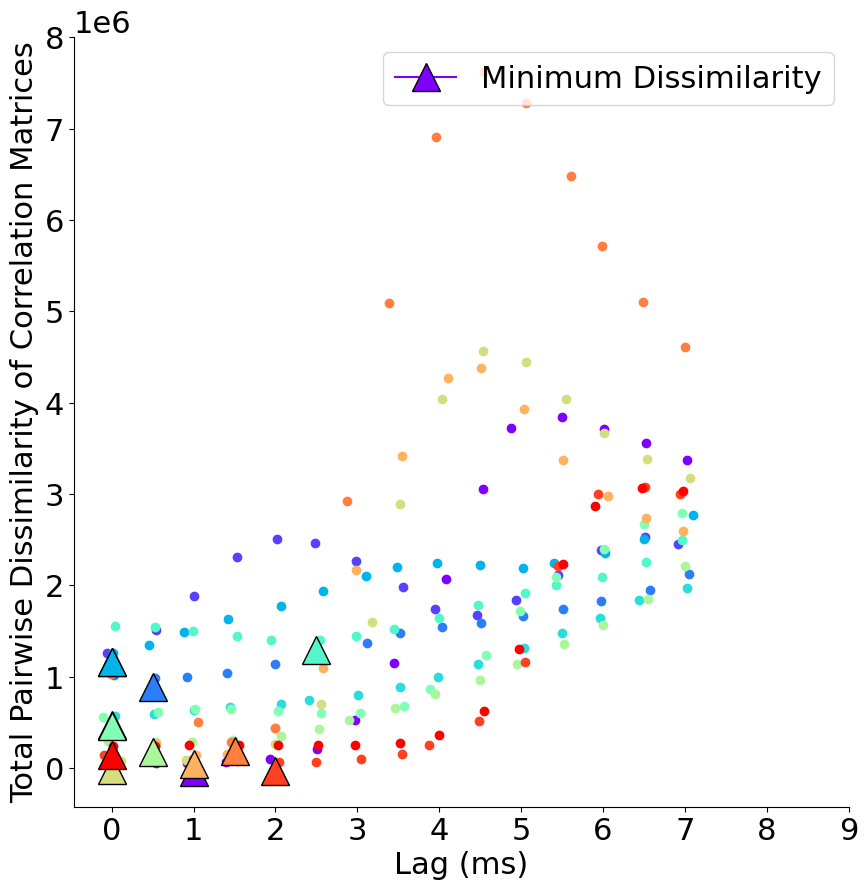

In [ ]:
# scatter plot of the total_rdm_distances for each lag
fig, ax = plt.subplots(figsize=(10, 10))


'''ax.boxplot([total_rdm_distances[lag] for lag in lags], 
            positions=lags, widths=0.2, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.1),
            showfliers=False,
            medianprops=dict(color='black'))'''
colors = cm.rainbow(np.linspace(0, 1, len(total_rdm_distances[0])))
for lag in lags:            
    x_jitter = np.random.normal(0, 0.1, len(total_rdm_distances[lag]))
    
    for i in range(len(total_rdm_distances[lag])):
        ax.scatter(x_jitter[i] + lag, total_rdm_distances[lag][i], color=colors[i], label='Data')

for i in range(len(total_rdm_distances[0])):
    lag_seq = [total_rdm_distances[lag][i] for lag in lags]
    min_rdm = min(lag_seq)
    arg_min_rdm = lag_seq.index(min_rdm)

    # plot the min_rdm as a triangle marker
    ax.plot(arg_min_rdm, min_rdm-(10**5),
            marker='^', markersize=20, color=colors[i], label='Minimum Dissimilarity',
            markeredgecolor='black')

# create a legend for a single RDM min marker
handles, labels = ax.get_legend_handles_labels()
# create a new legend for the min markers only
min_handles = [handles[i] for i in range(len(handles)) if labels[i] == 'Minimum Dissimilarity']
min_labels = [labels[i] for i in range(len(labels)) if labels[i] == 'Minimum Dissimilarity']
ax.legend([min_handles[0]], [min_labels[0]], loc='upper right')

#ax.set_xlim(-0.5, 1.5)
ax.set_xticks([i for i in range(0, 20, 2)])
ax.set_xticklabels([str(i) for i in range(0, 10)])
ax.set_xlabel('Lag (ms)')

# turn of spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Total Pairwise Dissimilarity of Correlation Matrices')
plt.savefig(f"{output_fig_dir}/total_rdm_distances_lag_0.png")
plt.show()
plt.close(fig)

In [ ]:
corr_matrices.keys()

dict_keys([130, 50, 30, 20, 110, 100, 60, 70, 10, 80, 120, 90, 40])

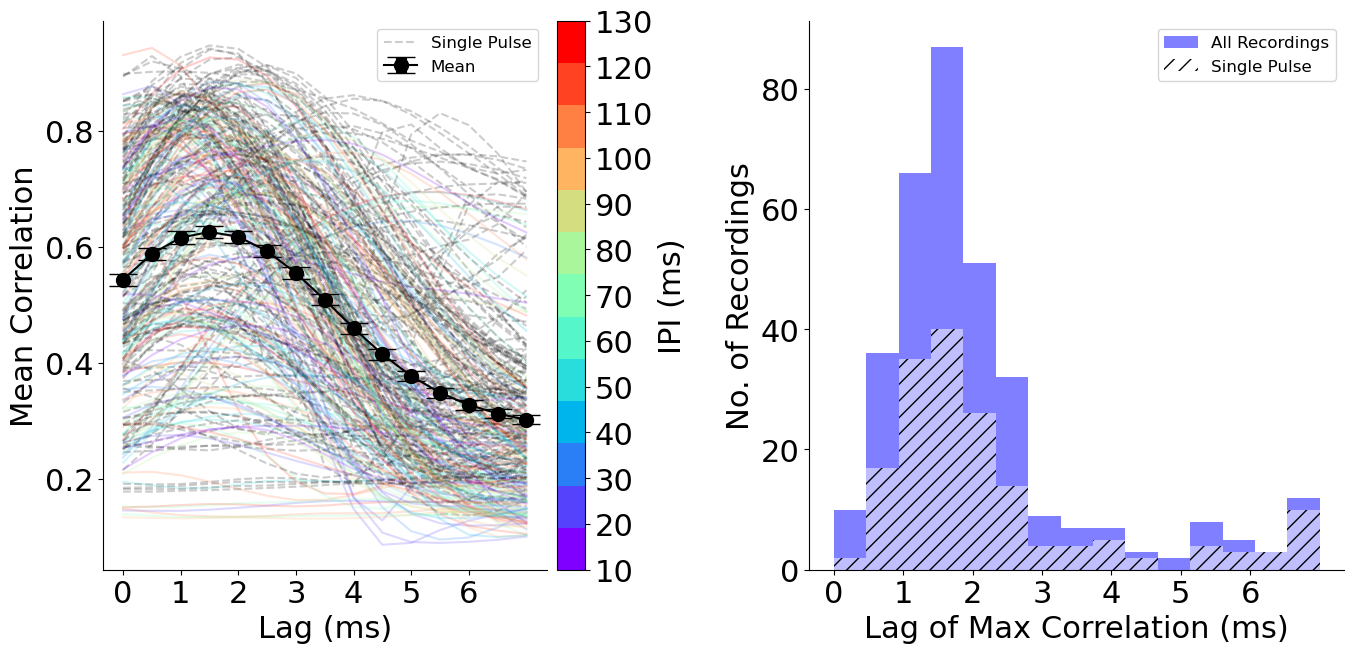

In [ ]:
# use corr_matrices[ipi][control_or_ppr_type][lag] to plot mean correlation for each lag
# each (ipi, control_or_ppr_type) pair is a different color
# do not use total_rdm_distances[lag] for this plot, but rather the mean of the correlation matrices

# 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ipi_colors = cm.rainbow(np.linspace(0, 1, len(corr_matrices.keys())))
ipis_sorted = list(corr_matrices.keys())
ipis_sorted.sort()
ipi_color_map = {ipi: ipi_colors[i] for i, ipi in enumerate(ipis_sorted)}

lags_of_max_corr = []
lags_of_max_corr_single = []
avg_corr_trace = []
for ipi in corr_matrices.keys():
    for control_or_ppr_type in corr_matrices[ipi].keys():
        for i in range(len(corr_matrices[ipi][control_or_ppr_type][0])):
                
                mean_corr = [np.mean(np.abs(corr_matrices[ipi][control_or_ppr_type][lag][i]))
                                for lag in lags]

                # get the lag with the maximum correlation value
                i_max_corr = np.argmax(mean_corr)
                lags_of_max_corr.append(lags[i_max_corr])

                if control_or_ppr_type == 1:
                        lags_of_max_corr_single.append(lags[i_max_corr])

                # plot the mean correlation for each lag
                ipi_color = ipi_color_map[ipi]
                color = ipi_color if control_or_ppr_type == 0 else 'black'
                ax[0].plot(lags, mean_corr, label=
                        'Single Pulse' if control_or_ppr_type == 1 else  "PPR", color=color,
                        linestyle='--' if control_or_ppr_type == 1 else '-', alpha=0.2)
                mean_corr = np.array(mean_corr).reshape(-1, len(lags))
                for i_corr in range(mean_corr.shape[0]):
                        mean_corr_single = mean_corr[i_corr, :].reshape(1, -1)
                        avg_corr_trace.append(mean_corr_single)
        
# plot the mean correlation for each lag with error bars
avg_corr_trace = np.concatenate(avg_corr_trace, axis=0)
ax[0].errorbar(lags, np.mean(avg_corr_trace, axis=0), yerr=sem(avg_corr_trace, axis=0),
            capsize=10, elinewidth=8, marker='o', markersize=10, label=f"Mean", color='black',)

# legend only shows the first entry
handles = [h for i, h in enumerate(ax[0].get_legend_handles_labels()[0]) if i % 2 == 0]
labels = [l for i, l in enumerate(ax[0].get_legend_handles_labels()[1]) if i % 2 == 0]
ax[0].legend(handles=handles[1:2] + [handles[-1]],
            labels=labels[1:2] + [labels[-1]],
            loc='upper right', fontsize=12)

# add a color bar to the plot
# create a colormap from the ipi_color_map
cmap = cm.get_cmap('rainbow', len(ipis_sorted))
norm = plt.Normalize(0, len(ipis_sorted) - 1)
cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                ticks=range(len(ipis_sorted)),
                #ticks=ipis_sorted,
                label='IPI (ms)',
                orientation='vertical',
                pad=0.02,
                ax=ax[0])
cbar.ax.set_yticklabels(ipis_sorted)

# turn of spines
for i in range(2):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

        ax[i].set_xticks([i for i in range(0, max_lag//2 * 2, 2)])
        ax[i].set_xticklabels([str(i) for i in range(0, max_lag // 2)])

ax[0].set_xlabel('Lag (ms)')
ax[1].set_xlabel('Lag of Max Correlation (ms)')


ax[0].set_xlabel('Lag (ms)')
ax[0].set_ylabel('Mean Correlation')


# right subplot is a histogram of lag_ofmax_corr
ax[1].hist(lags_of_max_corr, bins=max_lag, color='blue', alpha=0.5, label="All Recordings")

# hatched histogram for lags_of_max_corr_single
ax[1].hist(lags_of_max_corr_single, bins=max_lag, color='white', alpha=0.5,
            hatch='//', label='Single Pulse')
ax[1].legend(loc='upper right', fontsize=12)

ax[1].set_ylabel('No. of Recordings')

plt.tight_layout()
#ax.legend()
plt.savefig(f"{output_fig_dir}/mean_correlation_lags.png")
plt.show()



In [1]:
# Now use ROI_File and read the location of the ROIs using ROIFileReader
# Also read in the amp_array from the ppr_df and use that as the image to plot the ROIs locations on.
# The roi file is stored in a column in the ppr_df called 'ROI_File'
# The amp_array is stored in a column in the ppr_df called 'amp_array'

optimal_lag = 2  # based on the previous plot, this is the lag with the highest correlation
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

distance_vs_corr = {'distance': [], 'corr': []}
node_degree_dist = {}
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]
        for loc in slic_df['Location'].unique():
            loc_df = slic_df[slic_df['Location'] == loc]
            slic_loc_id = f"{slic}_{loc}"

            if date not in node_degree_dist:
                node_degree_dist[date] = {}
            if slic_loc_id not in node_degree_dist[date]:
                node_degree_dist[date][slic_loc_id] = {}
            print("Date: ", date, "Slice: ", slic, "Location: ", loc)

            ppr_barrel_subset = ppr_barrel_df[(ppr_barrel_df['Date'] == date) &
                    (ppr_barrel_df['Slice'] == slic) &
                    (ppr_barrel_df['Location'] == loc)]
            if len(ppr_barrel_subset) == 0:
                print("No ppr_barrel_df for this date/slice/location")
                continue
            
            # look up the amp_array in ppr_barrel_df
            amp_array = ppr_barrel_subset['amp_array'].values[0]
            amp_array = read_array_file(amp_array)

            # get roi_file for this recording
            roi_file_barrel_0 = loc_df[loc_df['ROI_Set'].str.contains('rand_0')]['ROI_File'].values[0]
            roi_file_barrel_1 = loc_df[loc_df['ROI_Set'].str.contains('rand_1')]['ROI_File'].values[0]
            
            # read the roi file (barrel 0)
            rois_0 = ROIFileReader(roi_file_barrel_0).get_roi_list()
            rois_0 = [LaminarROI(r, input_diode_numbers=True)
                    for r in rois_0]
            rois_points0 = [roi.get_points() for roi in rois_0]
            
            # read the roi file (barrel 1)
            rois_1 = ROIFileReader(roi_file_barrel_1).get_roi_list()
            rois_1 = [LaminarROI(r, input_diode_numbers=True)
                    for r in rois_1]
            rois_points1 = [roi.get_points() for roi in rois_1]
            
            # now get the correlation matrix for this date/slice/location
            avg_corr = []
            for ipi in corr_matrices_by_slice[date][slic_loc_id].keys():
                for control_or_ppr_type in corr_matrices_by_slice[date][slic_loc_id][ipi].keys():
                    try:
                        avg_corr.append(corr_matrices_by_slice[date][slic_loc_id][ipi][control_or_ppr_type][optimal_lag])
                    except IndexError:
                        print("IndexError: ", ipi, control_or_ppr_type, optimal_lag, i_slice)
                        print('len(corr_matrices_by_slice[date][slic_loc_id][ipi][control_or_ppr_type][optimal_lag]): ',
                            len(corr_matrices_by_slice[date][slic_loc_id][ipi][control_or_ppr_type][optimal_lag]))
                        continue
            avg_corr = np.array(avg_corr).reshape(-1, 100, 100)
            print("Avg corr shape: ", avg_corr.shape)
            avg_corr = np.mean(avg_corr, axis=0)
            
            # track these nodes' degrees (weighted by correlation value)
            key_roi1 = f"{x0}_{y0}"
            key_roi2 = f"{x1}_{y1}"
            # sum that node's row in the avg_corr matrix
            node_degree_dist[date][slic_loc_id] = {0: {}, 1: {}} # 0 for barrel 0, 1 for barrel 1
            node_degree_dist[date][slic_loc_id][0][key_roi1] = np.mean(avg_corr[i_1, :])
            node_degree_dist[date][slic_loc_id][1][key_roi2] = np.mean(avg_corr[:, i_2])

            if avg_corr.shape[0] < 10:
                print("Avg corr shape is too small: ", avg_corr.shape)
                continue

            # plot the amp_array and overlay the ROIs. 2 subplots
            fig, ax = plt.subplots(1, 2, figsize=(20, 10))
            ax[1].imshow(amp_array, cmap='rainbow', interpolation='nearest')

            # colorbar for the amp_array
            cbar = plt.colorbar(ax[1].imshow(amp_array, cmap='rainbow',
                     interpolation='nearest', vmin=np.min(amp_array), 
                     vmax=np.max(amp_array)), ax=ax[1])

            cbar.set_ticks([np.min(amp_array), np.max(amp_array)])
            cbar.set_ticklabels([str(round(np.min(amp_array), 2)), 
                                str(round(np.max(amp_array), 2))])
            cbar.ax.set_title(r'$\Delta F/F$', fontsize=22)            
            
            # plot the ROIs
            for roi in rois_points0:
                ax[1].scatter(roi[0][0], roi[0][1], color='red', alpha=0.5, label='Home Barrel')
            for roi in rois_points1:
                ax[1].scatter(roi[0][0], roi[0][1], color='blue', alpha=0.5, label='Neighbor Barrel')
            
            handles = [h for i, h in enumerate(ax[1].get_legend_handles_labels()[0]) if i % 2 == 0]
            labels = [l for i, l in enumerate(ax[1].get_legend_handles_labels()[1]) if i % 2 == 0]
            ax[1].legend(handles=[handles[0], handles[-1]], labels=[labels[0], labels[-1]],
                         loc='upper right', fontsize=12)

            # percentile threshold the avg_corr matrix to remove low values
            percentile_threshold = 0.97
            threshold = np.percentile(avg_corr, percentile_threshold * 100)

            for i_1, roi_1 in enumerate(rois_points0):
                for i_2, roi_2 in enumerate(rois_points1):
                    # draw a line between the two ROIs, 
                    # with the color of the correlation value

                    
                    corr = avg_corr[i_1, i_2]
                    x0, y0 = roi_1[0][0], roi_1[0][1]
                    x1, y1 = roi_2[0][0], roi_2[0][1]

                    # track the distribution of edge distances and correlation values
                    distance_vs_corr['distance'].append(np.sqrt((x0 - x1) ** 2 + (y0 - y1) ** 2))
                    distance_vs_corr['corr'].append(corr)

                    if corr < threshold:
                        continue
                    
                    color = plt.cm.hot(corr)
                    # plot the line between the two ROIs with outline on line
                    ax[1].plot([x0, x1], [y0, y1], color=color, linewidth=0.4)

            # plot the avg corr matrix on the left
            ax[0].imshow(avg_corr, cmap='hot', interpolation='nearest',
                    vmin=np.min(avg_corr), vmax=1)
            ax[0].set_title(f"Mean Correlation, {optimal_lag} ms Lag")

            plt.colorbar(ax[0].imshow(avg_corr, cmap='hot', interpolation='nearest',
                    vmin=np.min(avg_corr), vmax=1), ax=ax[0])
            # label colorbar with correlation values
            cbar.set_ticks([np.min(avg_corr), 1])
            cbar.set_ticklabels([str(round(np.min(avg_corr), 2)), 
                                str(1)])
            formatted_date = date.replace('/', '-')
            plt.savefig(f"{output_fig_dir}/{formatted_date}_{slic_loc_id}_"
                        f"static_fc_{barrels[i]}_{barrels[j]}-percentile_{str(int(percentile_threshold * 100))}-corr-rois.png")
            plt.show()



NameError: name 'ppr_df' is not defined

Date: 1/2/2025, Slice/Location: 1_3


NameError: name 'barrel' is not defined

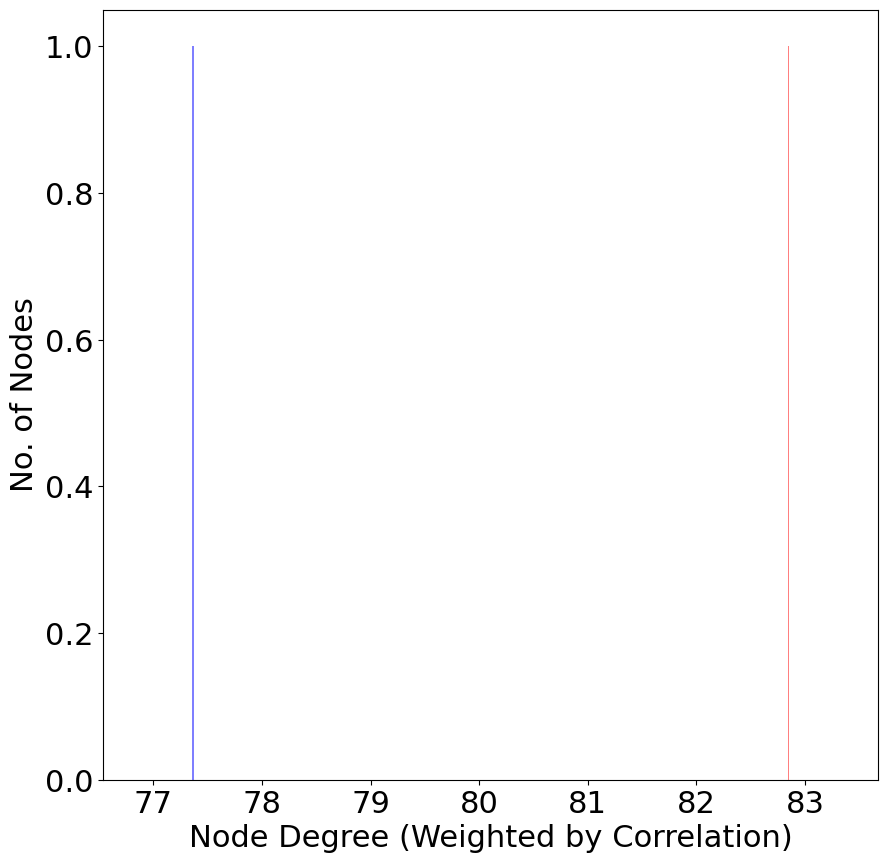

In [ ]:
for date in node_degree_dist.keys():
    for slic_loc_id in node_degree_dist[date].keys():
        print(f"Date: {date}, Slice/Location: {slic_loc_id}")
        # plot the distribution of node degrees
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.hist(list(node_degree_dist[date][slic_loc_id][1].values()), bins=100, color='blue', alpha=0.5, label='Neighbor Barrel')
        ax.hist(list(node_degree_dist[date][slic_loc_id][0].values()), bins=100, color='red', alpha=0.5, label='Home Barrel')
        ax.set_xlabel('Node Degree (Weighted by Correlation)')
        ax.set_ylabel('No. of Nodes')
        plt.savefig(f"{output_fig_dir}/{date}_{slic_loc_id}_"
                    f"node_degree_distribution_barrel_{barrel}_percentile{str(int(percentile_threshold * 100))}.png")
        plt.show()

In [ ]:
# Scatter plot of distance vs correlation in left subplot
fig, ax = plt.subplots(1, 2, figsize=(7, 14))
ax[0].scatter(distance_vs_corr['distance'] * um_per_px, distance_vs_corr['corr'], alpha=0.5)
ax[0].set_xlabel('Distance (um)')
ax[0].set_ylabel('Correlation')

# in right subplot, plot the histogram of the node degree at this percentile threshold
# separate by barrel
ax[1].hist(, bins=100, color='blue', alpha=0.5)
ax[1].set_xlabel('Correlation')
ax[1].set_ylabel('Node Deg')

#distance_vs_corr = {'distance': [], 'corr': []}


In [ ]:
node_degree_dist = {}

## 